# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [4]:
print(X_train_feats.shape)
print(X_val_feats.shape)
print(X_test_feats.shape)

(49000, 155)
(1000, 155)
(1000, 155)


## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [15]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-6, 2e-6, 5e-6, 1e-5]
#learning_rates = np.linspace(learning_rates[0],learning_rates[1], 3, endpoint=True)
regularization_strengths = [1e3, 2e3, 5e3, 1e4]
#regularization_strengths = np.linspace(regularization_strengths[0],regularization_strengths[1], 8, endpoint=True)

# Fixed hyperparameters
learning_rates = [2e-6]
#regularization_strengths = [1e4]

results = {}
best_val = -1
best_svm = None
best_lr_reg = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
num_iters = 1500
for current_lr in learning_rates: #go over the learning rates
    for current_reg in regularization_strengths:#go over the regularization strength
        
        svm = LinearSVM()
        loss_history = svm.train(X_train_feats, y_train, learning_rate=current_lr, reg=current_reg,
                      num_iters=num_iters, batch_size=512, verbose=False)
        
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)        
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        
        # FIX storing results
        results[(current_lr, current_reg)] = (train_acc, val_acc, loss_history)

        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
            best_lr_reg = (current_lr, current_reg)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy, _ = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
print('    learning rate: %e, regularization_strengths: %e' % best_lr_reg)

lr 2.000000e-06 reg 1.000000e+03 train accuracy: 0.413857 val accuracy: 0.412000
lr 2.000000e-06 reg 2.000000e+03 train accuracy: 0.414714 val accuracy: 0.421000
lr 2.000000e-06 reg 5.000000e+03 train accuracy: 0.414878 val accuracy: 0.419000
lr 2.000000e-06 reg 1.000000e+04 train accuracy: 0.414408 val accuracy: 0.414000
best validation accuracy achieved during cross-validation: 0.421000
    learning rate: 2.000000e-06, regularization_strengths: 2.000000e+03


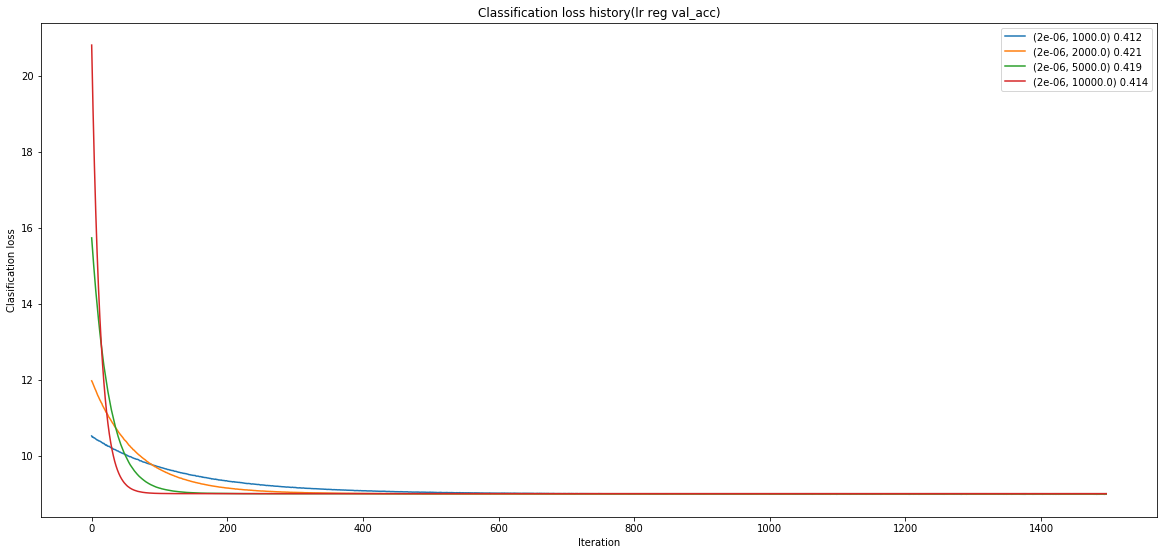

In [16]:
# Plot the loss function and train / validation accuracies
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_svm_loss_history(results, st = 0):    
    plt.subplot(2, 1, 1)
    for params, (_, val_acc, loss_history) in sorted(results.items()):
        plt.plot(loss_history[st:], label=str(params)+' '+str(val_acc))
    plt.title('Classification loss history(lr reg val_acc)')
    plt.xlabel('Iteration')
    plt.ylabel('Clasification loss')
    plt.legend()
    plt.show()
    
st = int(num_iters / 500)
show_svm_loss_history(results, st)

In [20]:
#train best model deeply
import copy
svm = copy.deepcopy(best_svm)
deep_num_iters = 0
svm.train(X_train_feats, y_train, learning_rate=best_lr_reg[0], reg=best_lr_reg[1],
                      num_iters=deep_num_iters, batch_size=512, verbose=False)
y_val_pred = svm.predict(X_val_feats)
val_acc = np.mean(y_val == y_val_pred)
print('final validation accuracy achieved during train best_svm deeply: %f' % val_acc)
print('    learning rate: %e, regularization_strengths: %e' % best_lr_reg)

final validation accuracy achieved during train best_svm deeply: 0.421000
    learning rate: 2.000000e-06, regularization_strengths: 2.000000e+03


In [21]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.424


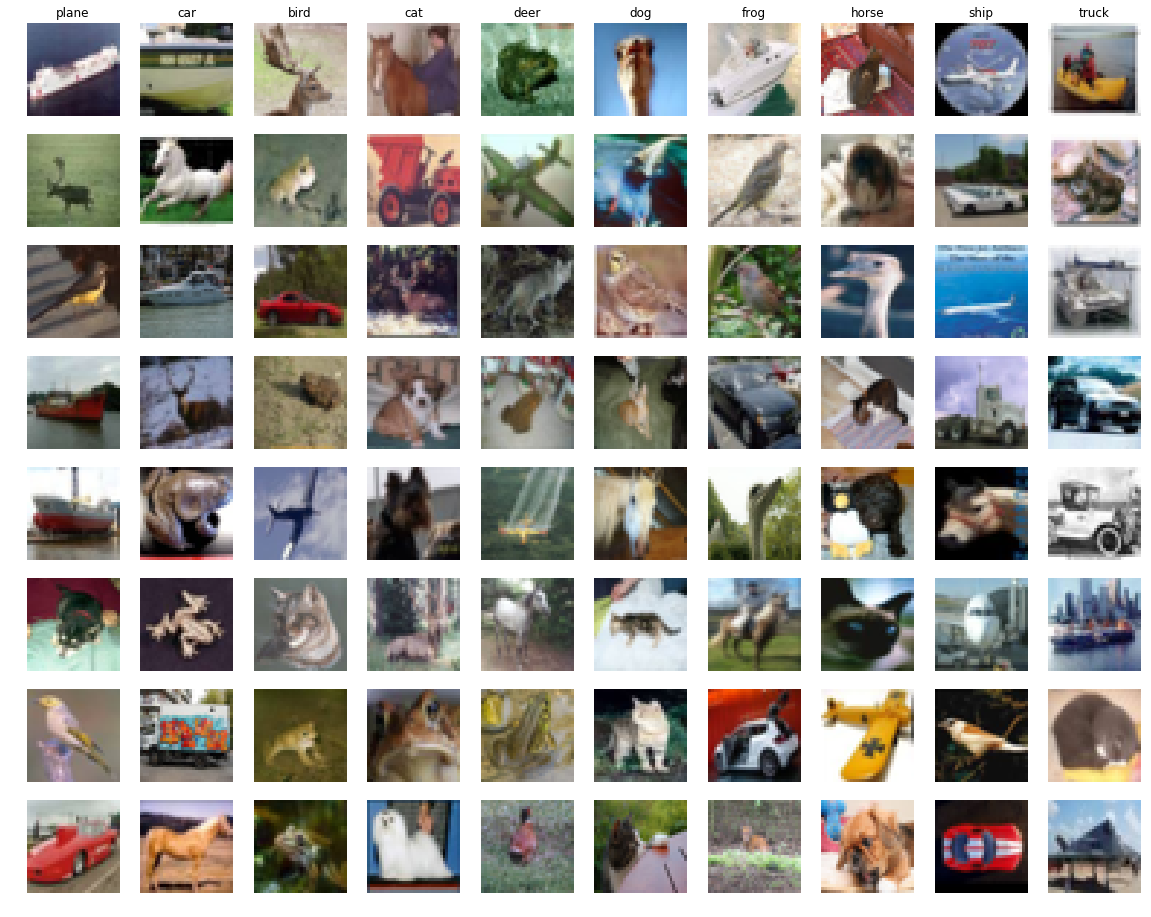

In [22]:
# Plot the loss function and train / validation accuracies
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [23]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [121]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
num_classes = 10

best_net = None
best_val = -1
best_net_history = None
best_params = None

In [128]:
# Hyperparameters Range
hidden_size = [100, 500]
range_hs = np.linspace(hidden_size[0], hidden_size[1], 4, endpoint=True, dtype=np.int32)
learning_rates = [0.01, 2.5]
range_lr = np.linspace(learning_rates[0],learning_rates[1], 10, endpoint=True)
learning_rate_decay = [0.95, 0.8]
range_lrd = np.linspace(learning_rate_decay[0],learning_rate_decay[1], 2, endpoint=True)
regularization_strengths = [5e-2, 5e-4]
range_reg = np.linspace(regularization_strengths[0],regularization_strengths[1], 5, endpoint=True)

# Fix hyperparameters
range_hs = np.array([750])
range_lr = np.array([0.5])
range_lrd = np.array([0.95])
range_reg = np.array([5e-4])

In [129]:
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
from collections import namedtuple
HyperParams = namedtuple("HyperParams", "hidden_size learning_rate learning_rate_decay regularization_strength")

results = {'variables':['hidden_size','learning_rate','reg'], 'history':[]}
# Fixed parameters
num_iters = 5000
batch_size = 256
print('Train epoches: %f' % (num_iters/int(max(X_train.shape[0] / batch_size, 1))))
for current_hs in range_hs:
    for current_lr in range_lr: #go over the learning rates
        for current_lrd in range_lrd:
            for current_reg in range_reg:#go over the regularization strength
                # Hyperparameters
                params = HyperParams(\
                                     hidden_size=current_hs,\
                                     learning_rate=current_lr, learning_rate_decay=current_lrd,\
                                     regularization_strength=current_reg)
                net = TwoLayerNet(input_dim, params.hidden_size, num_classes)
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                            num_iters=num_iters, batch_size=batch_size,
                            learning_rate=params.learning_rate, learning_rate_decay=params.learning_rate_decay,
                            reg=params.regularization_strength, verbose=False)
                results['history'].append(stats)
                val_acc = (net.predict(X_val_feats) == y_val).mean()
                if (val_acc > best_val) or (val_acc == best_val and stats['val_loss'] < best_net_history['val_loss']):
                    best_val = val_acc
                    best_net = net
                    best_params = params
                    best_net_history = stats

print('best validation accuracy achieved during cross-validation: %f' % best_val)
print('    hidden_size: %d, learning rate: %f, learning rate decay: %f, regularization_strengths: %f' \
      % (best_params.hidden_size,\
         best_params.learning_rate, best_params.learning_rate_decay,\
         best_params.regularization_strength))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Train epoches: 26.178010
best validation accuracy achieved during cross-validation: 0.603000
    hidden_size: 750, learning rate: 0.500000, learning rate decay: 0.950000, regularization_strengths: 0.000500


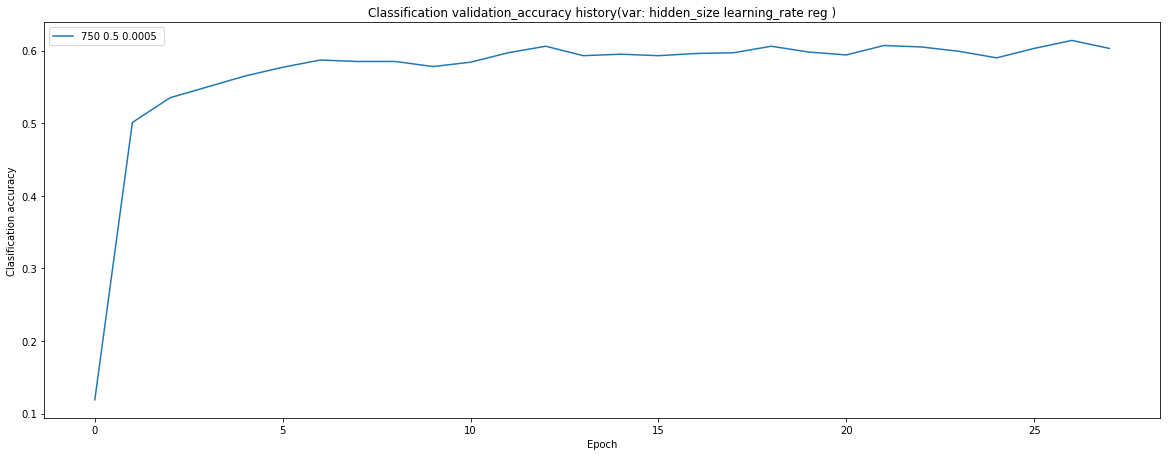

In [130]:
# visualize cross-validation loss history for each model
def show_cross_validation_history(results):
    plt.subplot(2, 1, 2)
    variables = results['variables']
    for stats in results['history']:
        val_acc_history = stats['val_acc_history']
        label = ''
        for var in variables:
            label += str(stats['params'][var])+' '
        plt.plot(val_acc_history, label=label)
    title = 'Classification validation_accuracy history(var:'
    for var in variables:
        title += ' '+var
    title += ' )'
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.legend()
    plt.show()
show_cross_validation_history(results)

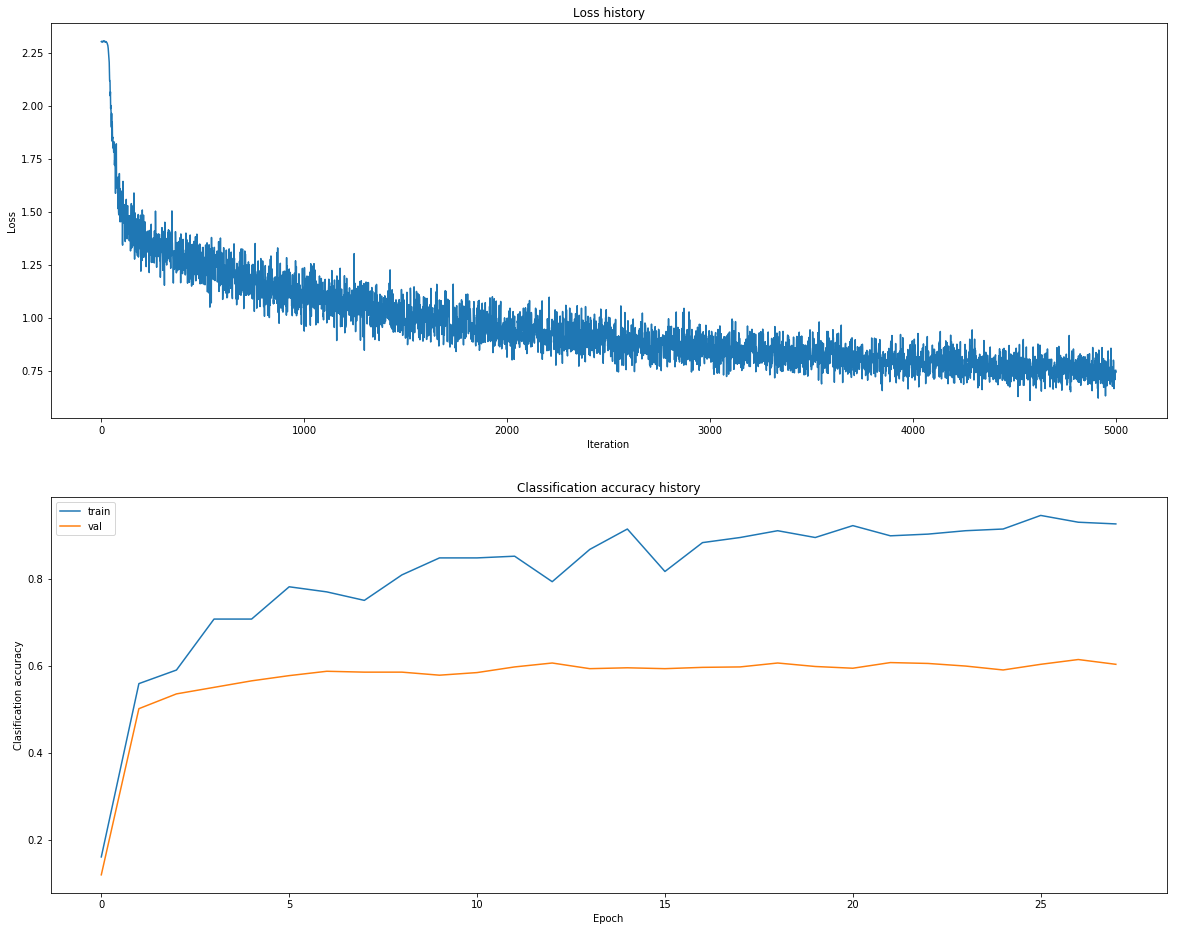

Last train accuracy: 0.925781 , validation accuracy: 0.603000 


In [131]:
# visualize loss history for best model 
def show_loss_history(stats):    
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.legend()
    plt.show()

show_loss_history(best_net_history)
print('Last train accuracy: %f , validation accuracy: %f ' \
      % (best_net_history['train_acc_history'][-1], best_net_history['val_acc_history'][-1]))

In [132]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.594
